# Navigation Project Report 

In this project, an agent is trained that navigates (and collect bananas!) in a large, square world. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The agent will be trained using a Deep Q Network and various implementations will be shown. To set up the environment, check the `README` file where all the details are provided.


# Description of the environment





In [1]:
from unityagents import UnityEnvironment
import numpy as np

# This variable should point to the executable of the particular platform
env = UnityEnvironment(file_name="Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 


# DQN  implementation
The first approach is using a DQN network, with Experience Memory replay and Iterative update that adjusts the action-calues (Q) towards target values that are periodically updated, therefore reducing correlations with the target. This approach is described in the famous paper by Deepmind [1].

## Description of the network

The network takes in a state vector of length 37 and outputs the action vector of length 4. Internally, it consists of 3 fully convolutional layers (FC1-3). FC1 and FC2 both consist of 64 units and each one is followed by a RELU activation layer. FC3 provides the probabilities of each action. This network manages to achieve the target of +13 as an average of last 100 episodes.

## Learning Algorithm
The learning algorithm is the one described in the paper:

![DQN algorithm](images/dqn_algorithm.png)




## Simulation of the environment

In [3]:
import sys
sys.path.append('./code')


env = UnityEnvironment(file_name="Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size


### Train 
from dqn_agent import Agent
import matplotlib.pyplot as plt
import torch
from collections import namedtuple, deque


env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
n_episodes = 1000

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

def dqn(n_episodes=n_episodes, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.52
Episode 200	Average Score: 3.54
Episode 300	Average Score: 6.51
Episode 400	Average Score: 9.44
Episode 500	Average Score: 12.38
Episode 600	Average Score: 13.72
Episode 700	Average Score: 14.19
Episode 800	Average Score: 14.97
Episode 900	Average Score: 15.55
Episode 1000	Average Score: 15.57


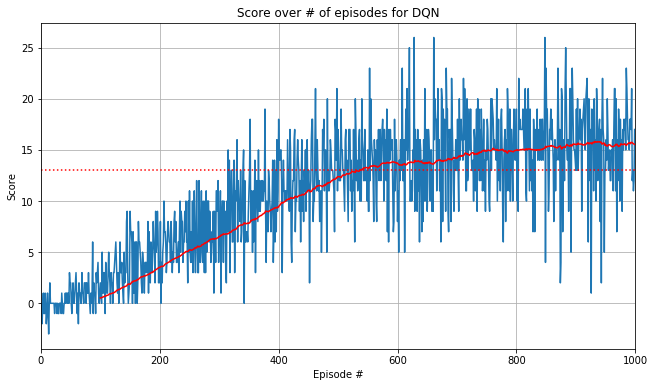

In [6]:
avg_scores = []
avg_x = np.arange(100,n_episodes)
for i in range(len(scores)):
    if i >= 100:
        avg_scores.append(np.average(scores[i-100:i]))
        
        
# plot the scores
fig = plt.figure(figsize=(10.65,6),  )
ax = fig.add_subplot(111)

plt.plot(np.arange(len(scores)), scores)
plt.plot(avg_x,avg_scores,'r')
plt.axhline(y=13,  linestyle='dotted', color='r')

plt.xlim(0,n_episodes)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.title("Score over # of episodes for DQN")
plt.show()


The blue line corresponds to the reward of each episode. While the training progresses a maximum value of +26 can be achieved. A more representative performance number is the moving average of last 100 episodes indicated by the red line. After approximately 530 episodes the target of +13 is overtaken. 

In orger to show the improvement of the trained network Agent over an agent that chooses random actions, two runs are simulated as shown in the follwoing section. 

### Random action Agent

In [9]:
# This variable should point to the executable of the particular platform
env = UnityEnvironment(file_name="Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 0.0


The score is quite bad. See https://youtu.be/9jzfIn5_X9A for the visualized performance. 

### DQN Agent 

In [11]:
env = UnityEnvironment(file_name="Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# examine the state space 
state = env_info.vector_observations[0]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
print("Score: {}".format(score))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 20.0


A much better score is achieved with the trained agent. For visual behaviour follow the video: https://youtu.be/dc0FCB2YwCs

## Double DQN
As explained in the original prososal paper [2] and in other resources [3] the Q-values in the DQN agent are overestimated by considering the best action to be the maxQ function. Especially at the beggining the value of Q function is affected by noise. As an improvement, the selected action and the generation of the target Q-value are seperated by using two identical in architecture but different in value networks.  

Knowing the $max(x) := x[argmax(x)]$ we can use different values in the second part of the equation. In our case, as implement in the file `code/ddqn_agent`

Similarly as with the DQN agent the code is identical with the only change being the agent

In [ ]:
env = UnityEnvironment(file_name="Banana.x86_64")

### Train 
from ddqn_agent import Agent

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
n_episodes = 1000

agent2 = Agent(state_size=state_size, action_size=action_size, seed=0)

def ddqn(n_episodes=n_episodes, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):
            action = agent2.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent2.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent2.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores2 = ddqn()
env.close()

# Ideas for Future Work



# References
[1] [Human-level control through deep reinforcement learing](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

[2] [Deep Reinforcement Learning with Double Q-Learning](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12389/11847)

[3] https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
 

## Summary of videos
- Agent behaving randomly: https://youtu.be/9jzfIn5_X9A
- DQN trained agent: https://youtu.be/dc0FCB2YwCs

### pending actions 


save weights

<bound method Module.state_dict of QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)>